In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

df = pd.read_excel('Online Retail.xlsx')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Data Cleaning**

In [12]:
df.info()

print("\nMissing values per column:\n")
print(df.isnull().sum())

df.dropna(subset=['CustomerID', 'Description'], inplace=True)

# Remove rows with negative Quantity or UnitPrice (likely returns or errors)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Remove canceled invoices — they usually start with 'C'
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Create TotalPrice column for each transaction (Quantity * Unit Price)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

Missing values per column:

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (tot

In [13]:
# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Snapshot Date:", snapshot_date)

# Group by CustomerID and calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                     # Frequency (number of orders)
    'TotalPrice': 'sum'                                         # Monetary (total spent)
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()

Snapshot Date: 2011-12-10 12:50:00


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [14]:
# Recency score: lower days = higher score
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])

# Frequency score: higher orders = higher score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# Monetary score: higher spend = higher score
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine into a single RFM Segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Calculate overall RFM Score (sum of individual scores)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12346.0,326,1,77183.60,1,1,4,114,6
1,12347.0,2,7,4310.00,4,4,4,444,12
2,12348.0,75,4,1797.24,2,3,4,234,9
3,12349.0,19,1,1757.55,3,1,4,314,8
4,12350.0,310,1,334.40,1,1,2,112,4


In [15]:
def segment_customer(row):
    if row['RFM_Score'] >= 10:
        return 'Champions'
    elif row['RFM_Score'] >= 8:
        return 'Loyal Customers'
    elif row['RFM_Score'] >= 6:
        return 'Potential Loyalist'
    elif row['RFM_Score'] >= 4:
        return 'Need Attention'
    else:
        return 'At Risk'

rfm['Customer_Segment'] = rfm.apply(segment_customer, axis=1)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Customer_Segment
0,12346.0,326,1,77183.60,1,1,4,114,6,Potential Loyalist
1,12347.0,2,7,4310.00,4,4,4,444,12,Champions
2,12348.0,75,4,1797.24,2,3,4,234,9,Loyal Customers
3,12349.0,19,1,1757.55,3,1,4,314,8,Loyal Customers
4,12350.0,310,1,334.40,1,1,2,112,4,Need Attention


In [17]:
print(rfm.columns)

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score',
       'M_Score', 'RFM_Segment', 'RFM_Score', 'Customer_Segment'],
      dtype='object')


In [18]:
rfm['Customer_Segment'] = rfm.apply(segment_customer, axis=1)

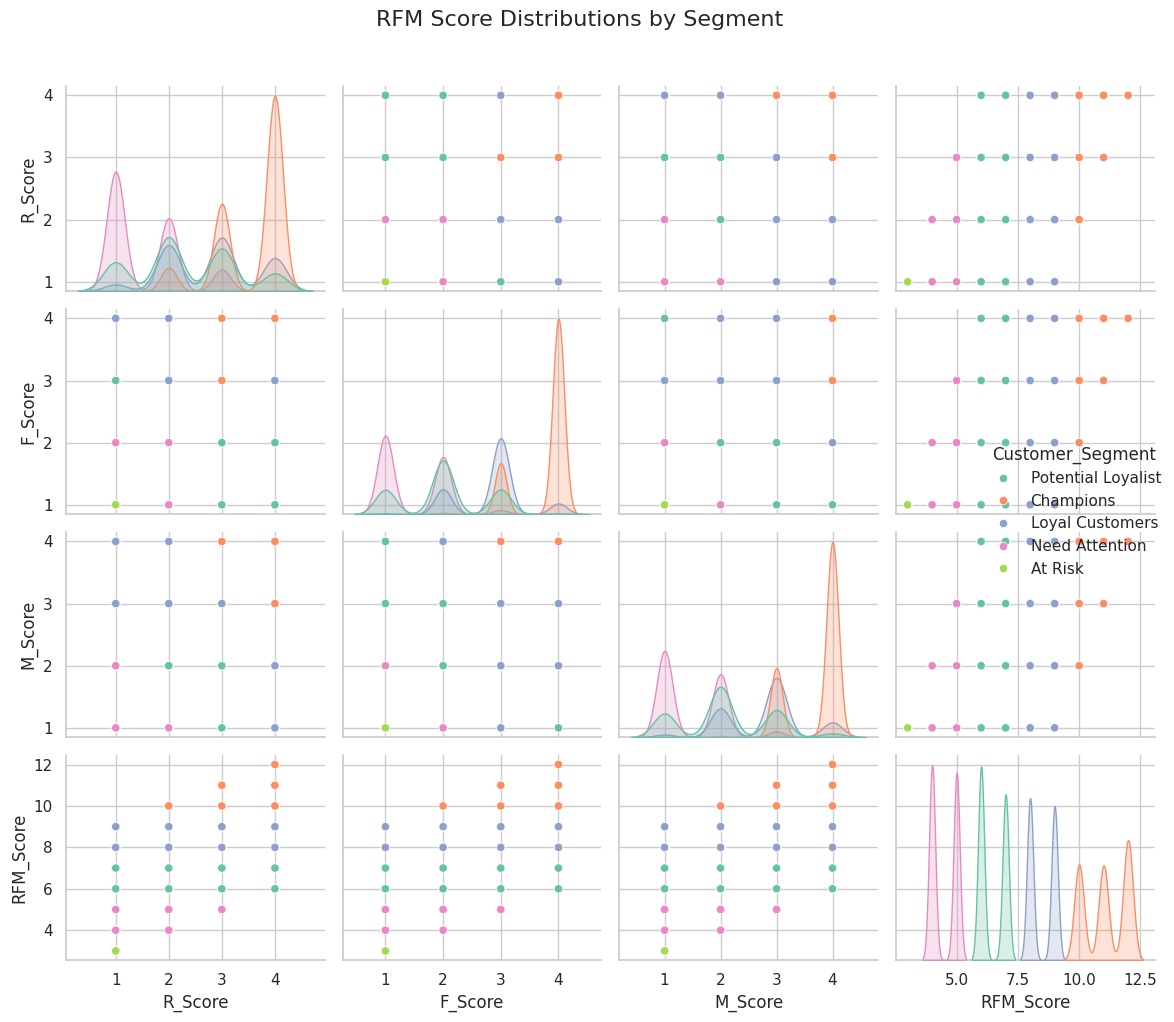

In [19]:
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

sns.pairplot(rfm[['R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Customer_Segment']],
             hue='Customer_Segment', palette='Set2')
plt.suptitle('RFM Score Distributions by Segment', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


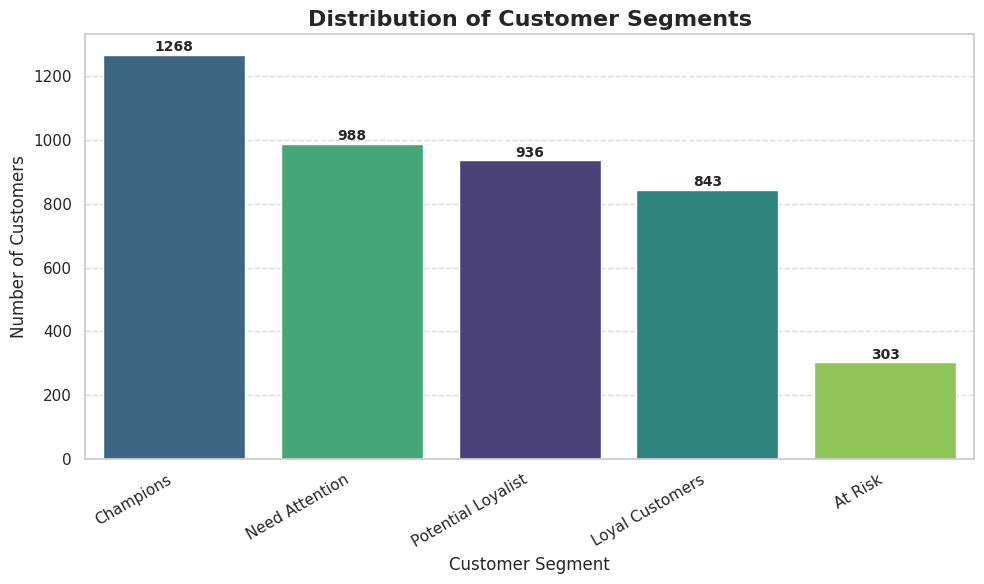

In [20]:
plt.figure(figsize=(10,6))
sns.countplot(
    data=rfm,
    x='Customer_Segment',
    hue='Customer_Segment',
    order=rfm['Customer_Segment'].value_counts().index,
    palette='viridis',
    dodge=False,
    legend=False  # avoids duplicate legends
)

# Styling
plt.title('Distribution of Customer Segments', fontsize=16, fontweight='bold')
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add count labels above bars
for i, count in enumerate(rfm['Customer_Segment'].value_counts()):
    plt.text(i, count + 2, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

**Visualization Theme**

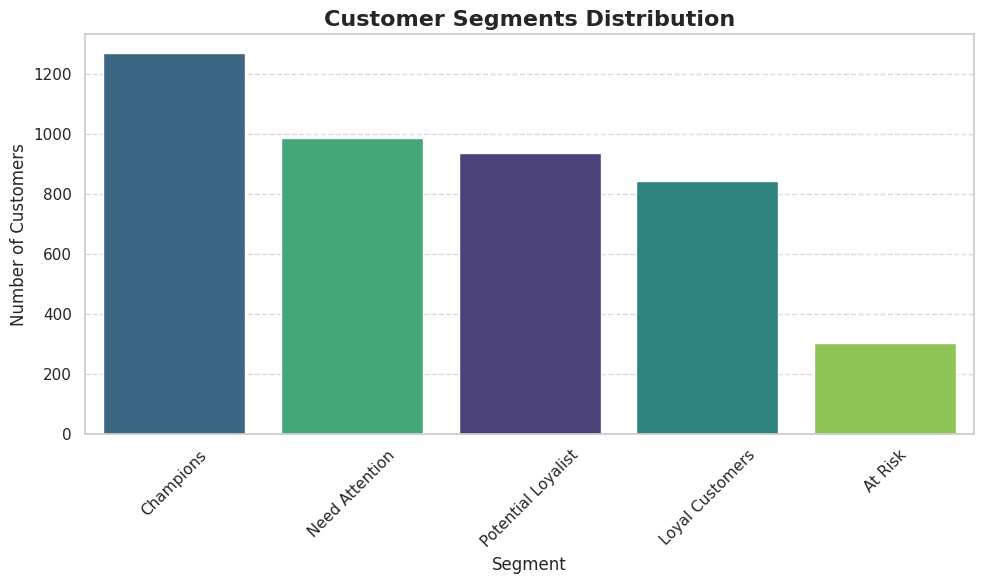

In [21]:
plt.figure(figsize=(10,6))
sns.countplot(
    data=rfm,
    x='Customer_Segment',
    hue='Customer_Segment',
    order=rfm['Customer_Segment'].value_counts().index,
    palette='viridis',
    dodge=False,
    legend=False  # Avoid double legends since hue = x
)
plt.title('Customer Segments Distribution', fontsize=16,fontweight='bold')
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

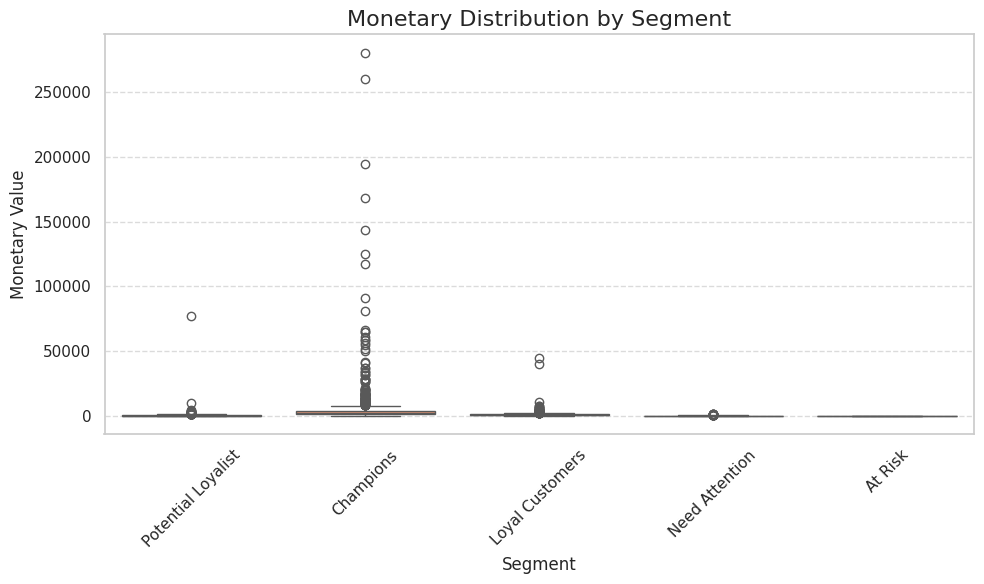

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=rfm,
    x='Customer_Segment',
    y='Monetary',
    hue='Customer_Segment',         # add this to safely use palette
    palette='Set2',
    dodge=False
)
plt.legend([],[], frameon=False)
plt.title('Monetary Distribution by Segment', fontsize=16)
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Monetary Value', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Market Recommendations By Segment**

We translate RFM segments into actionable marketing ideas you can implement immediately.

In [23]:
# Create marketing recommendations for each segment found in this notebook
segment_actions = {
    'Champions': 'Early access, VIP perks, premium upsell, referral incentives',
    'Loyal Customers': 'Loyalty program tiers, exclusive bundles, personalized recommendations',
    'Potential Loyalist': 'Welcome series, first-purchase coupon, nurture with relevant content',
    'Need Attention': 'Win-back emails, limited-time discounts, ask for feedback',
    'At Risk': 'Reactivation campaigns, steep discounts, survey to understand churn drivers'
}

# Attach actions to each customer
rfm['Recommended_Action'] = rfm['Customer_Segment'].map(segment_actions)

# Summarize segment size and monetary value
segment_summary = (
    rfm.groupby('Customer_Segment')
       .agg(
           Customers=('CustomerID','nunique'),
           Avg_Recency=('Recency','mean'),
           Avg_Frequency=('Frequency','mean'),
           Avg_Monetary=('Monetary','mean'),
           Total_Monetary=('Monetary','sum')
       )
       .sort_values('Total_Monetary', ascending=False)
       .reset_index()
)

# Merge actions for display
segment_summary['Recommended_Action'] = segment_summary['Customer_Segment'].map(segment_actions)

print("=== Segment Summary with Recommended Actions ===")
display(segment_summary)

# Optional: save outputs
segment_summary.to_csv('rfm_segment_summary.csv', index=False)
rfm.to_csv('rfm_customers_with_rfm_and_actions.csv', index=False)
print("\nSaved: rfm_segment_summary.csv and rfm_customers_with_rfm_and_actions.csv")

=== Segment Summary with Recommended Actions ===


,Customer_Segment,Customers,Avg_Recency,Avg_Frequency,Avg_Monetary,Total_Monetary,Recommended_Action
0,Champions,1268,19.896688,9.913249,5397.511680,6844044.810,"Early access, VIP perks, premium upsell, refer..."
1,Loyal Customers,843,52.154211,3.234875,1249.621425,1053430.861,"Loyalty program tiers, exclusive bundles, pers..."
2,Potential Loyalist,936,87.365385,1.865385,699.064885,654324.732,"Welcome series, first-purchase coupon, nurture..."
3,Need Attention,988,171.366397,1.200405,313.919161,310152.131,"Win-back emails, limited-time discounts, ask f..."
4,At Risk,303,267.801980,1.000000,163.219043,49455.370,"Reactivation campaigns, steep discounts, surve..."



Saved: rfm_segment_summary.csv and rfm_customers_with_rfm_and_actions.csv


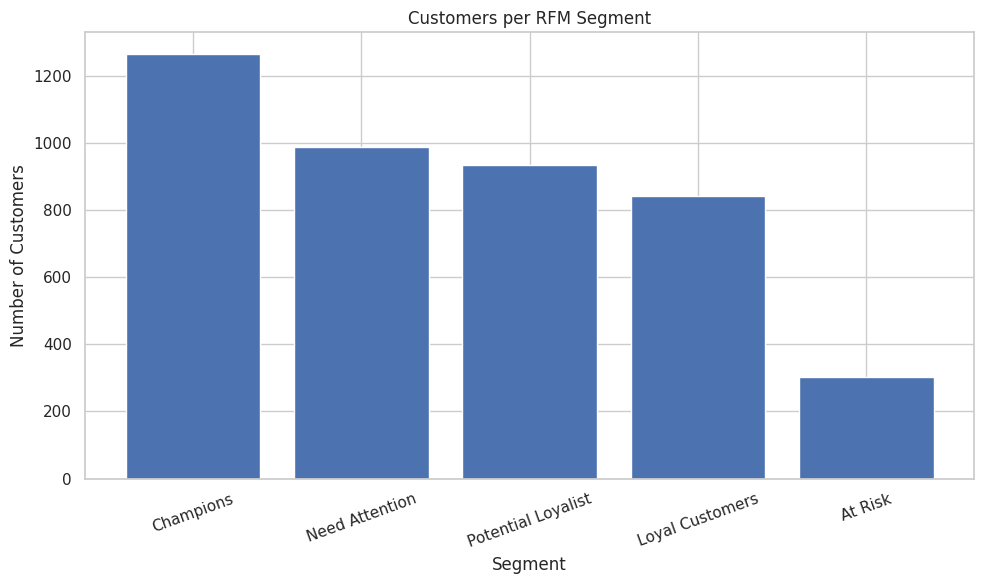

In [24]:
counts = rfm['Customer_Segment'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(counts.index, counts.values)
plt.title('Customers per RFM Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

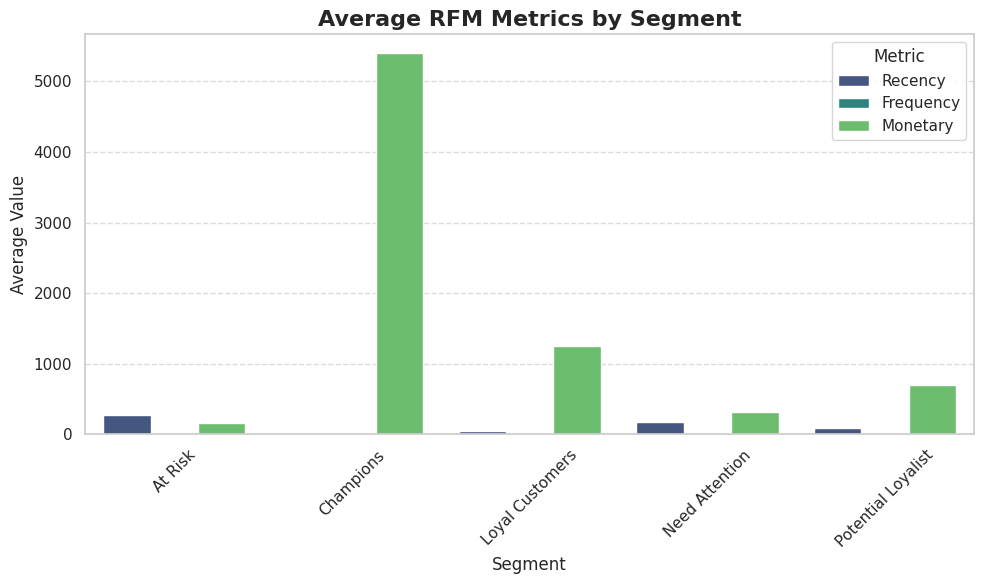

In [25]:
# Prepare data
rfm_summary = rfm.groupby('Customer_Segment')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()
rfm_summary_melted = rfm_summary.melt(id_vars='Customer_Segment', var_name='Metric', value_name='Average')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=rfm_summary_melted,
    x='Customer_Segment',
    y='Average',
    hue='Metric',
    palette='viridis'
)

plt.title('Average RFM Metrics by Segment', fontsize=16, fontweight='bold')
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric', loc='upper right')
plt.tight_layout()
plt.show()

**Heatmap**

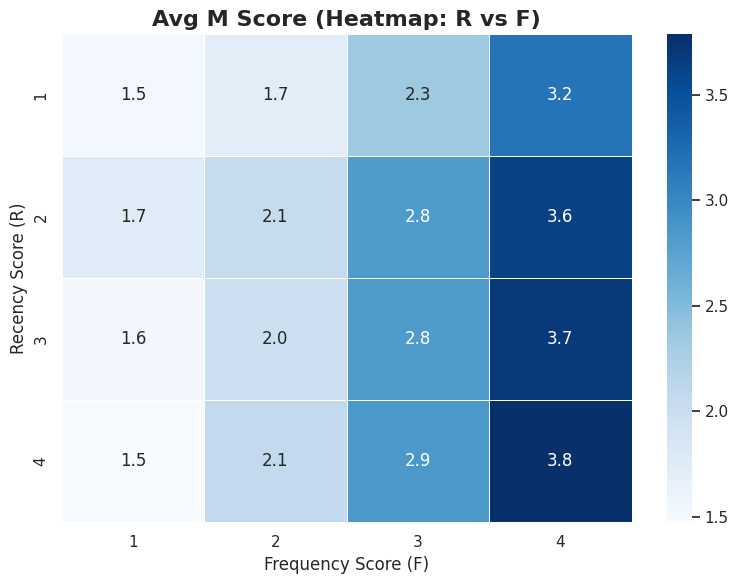

In [26]:
# Convert R, F, M scores to integers if not already
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Create pivot table
rfm_pivot = rfm.pivot_table(index='R_Score', columns='F_Score', values='M_Score', aggfunc='mean')

plt.figure(figsize=(8,6))
sns.heatmap(rfm_pivot, cmap='Blues', annot=True, fmt=".1f", linewidths=.5)

plt.title('Avg M Score (Heatmap: R vs F)', fontsize=16, weight='bold')
plt.xlabel('Frequency Score (F)')
plt.ylabel('Recency Score (R)')
plt.tight_layout()
plt.show()